# [Hands-On] Bag-of-Words & TF-IDF

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> 교육 목적

**Copyright**: All rights reserved

---

## 개요

텍스트를 숫자 벡터로 변환하는 가장 기본적인 방법들을 학습합니다.

**학습 내용**:
1. Bag-of-Words (BoW) 모델의 원리 이해
2. TF-IDF 개념과 계산 방법
3. 실제 의료 판독문 데이터 분석

---

## 1. 데이터 다운로드 및 환경 설정

In [ ]:
# Colab 환경 체크 및 데이터 다운로드
import os
import sys

# Colab 환경인지 확인
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Google Colab 환경 감지")

    # 데이터 파일이 없으면 다운로드
    if not os.path.exists('medical_reports.tsv'):
        print("데이터 파일 다운로드 중...")

        # Dropbox 링크를 직접 다운로드 가능한 URL로 변경
        # dl=0을 dl=1로 변경
        url = "https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1"

        !wget -O medical_reports.tsv "{url}"

        print("✓ 데이터 다운로드 완료!")
    else:
        print("✓ 데이터 파일이 이미 존재합니다.")

    # 한글 폰트 설정 (오프라인 환경에서도 에러 없이 동작하도록 안전 가드 포함)
    print("한글 폰트 설정 중...")
    !wget -q -O NanumGothic.ttf "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

    import warnings
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    path = "NanumGothic.ttf"
    if os.path.exists(path) and os.path.getsize(path) > 100_000:
        fm.fontManager.addfont(path)
        family_name = fm.FontProperties(fname=path).get_name()
        mpl.rcParams["font.family"] = family_name
    mpl.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore")

    print("✓ 한글 폰트 설정 완료!")

else:
    print("로컬 환경에서 실행 중")

Google Colab 환경 감지
데이터 파일 다운로드 중...
--2025-11-12 12:32:07--  https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca9f073ebdbe6b7302010532f5f.dl.dropboxusercontent.com/cd/0/inline/C1DPdhQotgr86nXIaNtErGRFYcaLykp3wdm2Qg1emqu6UuQJ8R735zoZvWv0ODeaqBYmv5mMJHddJT32T2sp5ctSOsCCK2PbGGURSbpqfM5GxISOMi-MNq1q10reZsZ694U/file?dl=1# [following]
--2025-11-12 12:32:08--  https://uca9f073ebdbe6b7302010532f5f.dl.dropboxusercontent.com/cd/0/inline/C1DPdhQotgr86nXIaNtErGRFYcaLykp3wdm2Qg1emqu6UuQJ8R735zoZvWv0ODeaqBYmv5mMJHddJT32T2sp5ctSOsCCK2PbGGURSbpqfM5GxISOMi-MNq1q10reZsZ694U/file?dl=1
Resolving uca9f073ebdbe6b7302010532f5f.dl.dropboxusercontent.com (uca9f073ebdbe6b7302010532f5f.dl.dropboxusercontent.

## 2. 라이브러리 로드

In [ ]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from typing import List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
if IN_COLAB:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    # 로컬 환경에서는 시스템 폰트 사용
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        print("⚠ 한글 폰트가 없어 기본 폰트를 사용합니다.")

plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


---

## 3. Bag-of-Words (BoW) 기초

### 핵심 개념

**Bag-of-Words란?**
- 텍스트를 "단어들의 가방"으로 표현하는 방법
- 단어의 순서는 무시하고, 출현 빈도만 고려
- 각 문서를 고정된 길이의 벡터로 변환

**예시:**
```
문서1: "고양이가 밥을 먹는다"
문서2: "강아지가 밥을 먹는다"

어휘: [고양이, 강아지, 밥, 먹는다]

문서1 벡터: [1, 0, 1, 1]
문서2 벡터: [0, 1, 1, 1]
```

### 3.1 간단한 예제로 이해하기

In [ ]:
# 간단한 문서 모음
documents = [
    "우측 폐에 결절이 관찰됩니다",
    "좌측 폐에 음영이 관찰됩니다",
    "양측 폐에 결절과 음영이 관찰됩니다"
]

print("=" * 70)
print("원본 문서:")
print("=" * 70)
for i, doc in enumerate(documents, 1):
    print(f"문서 {i}: {doc}")
print()

원본 문서:
문서 1: 우측 폐에 결절이 관찰됩니다
문서 2: 좌측 폐에 음영이 관찰됩니다
문서 3: 양측 폐에 결절과 음영이 관찰됩니다



### 3.2 어휘 사전 구축

**분석 아이디어**:
- 모든 문서에서 등장하는 고유 단어들을 추출하여 어휘 사전을 만듭니다
- 이 어휘 사전이 벡터의 각 차원을 정의하게 됩니다

**접근 방법**:
1. 각 문서를 단어 단위로 분리 (토큰화)
2. 모든 문서의 단어를 합쳐서 중복 제거
3. 정렬하여 일관된 순서 유지

In [ ]:
def simple_tokenize(text: str) -> List[str]:
    """간단한 한국어 토큰화 (공백 기준)"""
    return text.split()

# 어휘 사전 구축
vocab = set()
for doc in documents:
    words = simple_tokenize(doc)
    vocab.update(words)

vocab = sorted(vocab)  # 일관된 순서를 위해 정렬

print("=" * 70)
print("어휘 사전 (Vocabulary):")
print("=" * 70)
for i, word in enumerate(vocab):
    print(f"{i}: {word}")
print(f"\n총 {len(vocab)}개의 고유 단어")
print()

어휘 사전 (Vocabulary):
0: 결절과
1: 결절이
2: 관찰됩니다
3: 양측
4: 우측
5: 음영이
6: 좌측
7: 폐에

총 8개의 고유 단어



### 3.3 Bag-of-Words 벡터 생성

**분석 아이디어**:
- 각 문서를 어휘 사전 크기의 벡터로 변환합니다
- 벡터의 각 위치는 해당 단어의 출현 횟수를 나타냅니다

**접근 방법**:
1. 각 문서의 단어를 카운트
2. 어휘 사전의 순서대로 빈도를 벡터로 변환

In [ ]:
def document_to_bow(doc: str, vocab: List[str]) -> np.ndarray:
    """문서를 BoW 벡터로 변환"""
    words = simple_tokenize(doc)
    word_counts = Counter(words)

    # 어휘 사전 순서대로 벡터 생성
    bow_vector = np.array([word_counts.get(word, 0) for word in vocab])
    return bow_vector

# 모든 문서를 BoW 벡터로 변환
bow_matrix = np.array([document_to_bow(doc, vocab) for doc in documents])

print("=" * 70)
print("Bag-of-Words 행렬 (Term-Document Matrix):")
print("=" * 70)
print("\n어휘 사전:", vocab)
print()

# 데이터프레임으로 시각화
bow_df = pd.DataFrame(bow_matrix, columns=vocab, index=[f"문서{i+1}" for i in range(len(documents))])
bow_df

Bag-of-Words 행렬 (Term-Document Matrix):

어휘 사전: ['결절과', '결절이', '관찰됩니다', '양측', '우측', '음영이', '좌측', '폐에']



,결절과,결절이,관찰됩니다,양측,우측,음영이,좌측,폐에
문서1,0,1,1,0,1,0,0,1
문서2,0,0,1,0,0,1,1,1
문서3,1,0,1,1,0,1,0,1


### 3.4 BoW 시각화

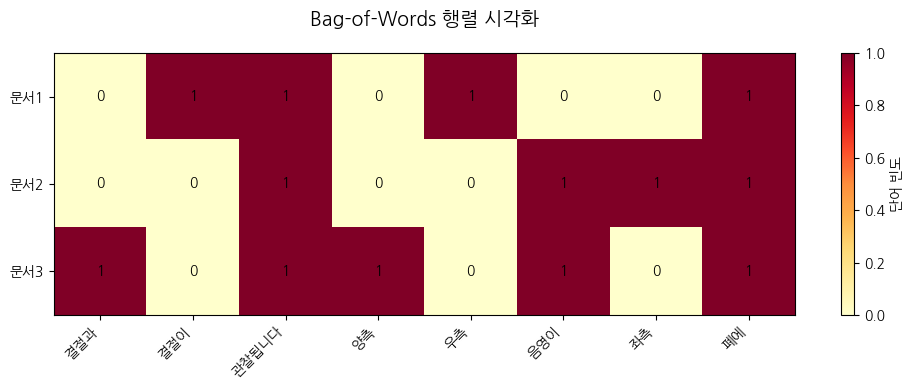

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# 히트맵 생성
im = ax.imshow(bow_matrix, cmap='YlOrRd', aspect='auto')

# 축 설정
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(documents)))
ax.set_xticklabels(vocab, rotation=45, ha='right')
ax.set_yticklabels([f'문서{i+1}' for i in range(len(documents))])

# 값 표시
for i in range(len(documents)):
    for j in range(len(vocab)):
        text = ax.text(j, i, bow_matrix[i, j],
                      ha="center", va="center", color="black", fontsize=10)

ax.set_title('Bag-of-Words 행렬 시각화', fontsize=14, pad=20)
plt.colorbar(im, ax=ax, label='단어 빈도')
plt.tight_layout()
plt.show()

---

## 4. TF-IDF (Term Frequency - Inverse Document Frequency)

### 핵심 개념

**TF-IDF란?**
- 단순 빈도수의 문제점을 보완한 가중치 방법
- 자주 등장하지만 덜 중요한 단어의 가중치를 낮춤
- 특정 문서에서만 자주 등장하는 단어의 가중치를 높임

**수식:**
```
TF-IDF = TF × IDF

TF (Term Frequency) = (단어의 출현 횟수) / (문서 내 전체 단어 수)

IDF (Inverse Document Frequency) = log(전체 문서 수 / 해당 단어가 출현한 문서 수)
```

### 4.1 TF (Term Frequency) 계산

**분석 아이디어**:
- 단어의 빈도를 정규화하여 문서 길이의 영향을 제거합니다
- 긴 문서와 짧은 문서를 공정하게 비교할 수 있게 됩니다

**접근 방법**:
1. 각 문서에서 단어의 출현 횟수를 카운트
2. 문서 내 전체 단어 수로 나누어 정규화

In [ ]:
def compute_tf(doc: str, vocab: List[str]) -> np.ndarray:
    """TF (Term Frequency) 계산"""
    words = simple_tokenize(doc)
    word_counts = Counter(words)
    total_words = len(words)

    # TF = 단어 출현 횟수 / 전체 단어 수
    tf_vector = np.array([word_counts.get(word, 0) / total_words for word in vocab])
    return tf_vector

# TF 행렬 계산
tf_matrix = np.array([compute_tf(doc, vocab) for doc in documents])

print("=" * 70)
print("TF (Term Frequency) 행렬:")
print("=" * 70)
tf_df = pd.DataFrame(tf_matrix, columns=vocab, index=[f"문서{i+1}" for i in range(len(documents))])
tf_df.round(3)

TF (Term Frequency) 행렬:


,결절과,결절이,관찰됩니다,양측,우측,음영이,좌측,폐에
문서1,0.0,0.25,0.25,0.0,0.25,0.00,0.00,0.25
문서2,0.0,0.00,0.25,0.0,0.00,0.25,0.25,0.25
문서3,0.2,0.00,0.20,0.2,0.00,0.20,0.00,0.20


### 4.2 IDF (Inverse Document Frequency) 계산

**분석 아이디어**:
- 많은 문서에 등장하는 단어는 덜 중요하다고 판단합니다
- 로그를 사용하여 값의 범위를 조절합니다

**접근 방법**:
1. 각 단어가 등장하는 문서의 수를 카운트
2. log(전체 문서 수 / 단어가 등장한 문서 수) 계산

In [ ]:
def compute_idf(documents: List[str], vocab: List[str]) -> np.ndarray:
    """IDF (Inverse Document Frequency) 계산"""
    N = len(documents)  # 전체 문서 수
    idf_vector = []

    for word in vocab:
        # 해당 단어가 포함된 문서 수
        doc_count = sum(1 for doc in documents if word in simple_tokenize(doc))

        # IDF = log(N / doc_count)
        idf = np.log(N / doc_count) if doc_count > 0 else 0
        idf_vector.append(idf)

    return np.array(idf_vector)

# IDF 계산
idf_vector = compute_idf(documents, vocab)

print("=" * 70)
print("IDF (Inverse Document Frequency) 벡터:")
print("=" * 70)
idf_df = pd.DataFrame({
    '단어': vocab,
    'IDF': idf_vector,
    '출현 문서 수': [sum(1 for doc in documents if word in simple_tokenize(doc)) for word in vocab]
})
idf_df.round(3)

IDF (Inverse Document Frequency) 벡터:


,단어,IDF,출현 문서 수
0,결절과,1.099,1
1,결절이,1.099,1
2,관찰됩니다,0.000,3
3,양측,1.099,1
4,우측,1.099,1
5,음영이,0.405,2
6,좌측,1.099,1
7,폐에,0.000,3


In [ ]:
# IDF 값 해석
print("\n💡 IDF 값 해석:")
print("-" * 70)
print("• IDF가 높을수록: 해당 단어가 적은 문서에만 등장 → 더 특별함")
print("• IDF가 낮을수록: 해당 단어가 많은 문서에 등장 → 더 일반적임")
print()


💡 IDF 값 해석:
----------------------------------------------------------------------
• IDF가 높을수록: 해당 단어가 적은 문서에만 등장 → 더 특별함
• IDF가 낮을수록: 해당 단어가 많은 문서에 등장 → 더 일반적임



### 4.3 TF-IDF 계산

**분석 아이디어**:
- TF와 IDF를 곱하여 최종 가중치를 계산합니다
- 문서 내에서 자주 등장하면서도 전체 문서에서는 드물게 등장하는 단어가 높은 점수를 받습니다

**접근 방법**:
1. 각 문서의 TF 벡터 계산
2. IDF 벡터와 element-wise 곱셈

In [ ]:
# TF-IDF 행렬 계산
tfidf_matrix = tf_matrix * idf_vector

print("=" * 70)
print("원본 문서:")
print("=" * 70)
for i, doc in enumerate(documents, 1):
    print(f"문서 {i}: {doc}")
print()


print("=" * 70)
print("TF-IDF 행렬:")
print("=" * 70)
tfidf_df = pd.DataFrame(tfidf_matrix, columns=vocab, index=[f"문서{i+1}" for i in range(len(documents))])
tfidf_df.round(3)


원본 문서:
문서 1: 우측 폐에 결절이 관찰됩니다
문서 2: 좌측 폐에 음영이 관찰됩니다
문서 3: 양측 폐에 결절과 음영이 관찰됩니다

TF-IDF 행렬:


,결절과,결절이,관찰됩니다,양측,우측,음영이,좌측,폐에
문서1,0.00,0.275,0.0,0.00,0.275,0.000,0.000,0.0
문서2,0.00,0.000,0.0,0.00,0.000,0.101,0.275,0.0
문서3,0.22,0.000,0.0,0.22,0.000,0.081,0.000,0.0


원본 문서:
문서 1: 우측 폐에 결절이 관찰됩니다
문서 2: 좌측 폐에 음영이 관찰됩니다
문서 3: 양측 폐에 결절과 음영이 관찰됩니다



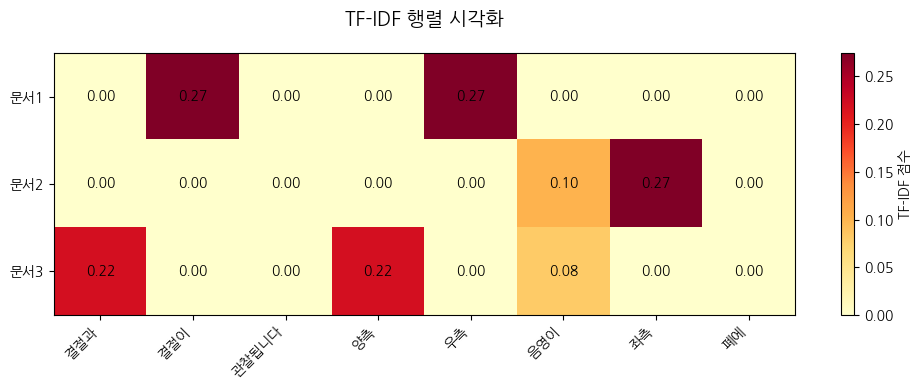

In [ ]:
print("=" * 70)
print("원본 문서:")
print("=" * 70)
for i, doc in enumerate(documents, 1):
    print(f"문서 {i}: {doc}")
print()


fig, ax = plt.subplots(figsize=(10, 4))

# 히트맵 생성
im = ax.imshow(tfidf_matrix, cmap='YlOrRd', aspect='auto')

# 축 설정
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(documents)))
ax.set_xticklabels(vocab, rotation=45, ha='right')
ax.set_yticklabels([f'문서{i+1}' for i in range(len(documents))])

# 값 표시
for i in range(len(documents)):
    for j in range(len(vocab)):
        text = ax.text(j, i, f'{tfidf_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=10)

ax.set_title('TF-IDF 행렬 시각화', fontsize=14, pad=20)
plt.colorbar(im, ax=ax, label='TF-IDF 점수')
plt.tight_layout()
plt.show()

### 4.4 BoW vs TF-IDF 비교 시각화

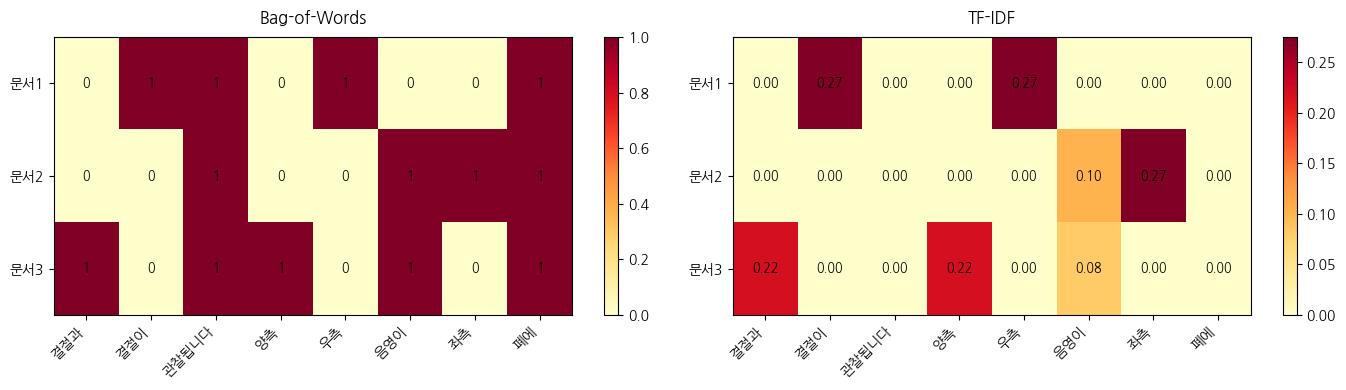


💡 비교 분석:
----------------------------------------------------------------------
• '관찰됩니다': 모든 문서에 등장 → TF-IDF에서 가중치 감소
• '결절', '음영': 특정 문서에만 등장 → TF-IDF에서 상대적으로 높은 가중치
• TF-IDF는 문서의 특징을 더 잘 포착합니다



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# BoW 히트맵
im1 = axes[0].imshow(bow_matrix, cmap='YlOrRd', aspect='auto')
axes[0].set_xticks(np.arange(len(vocab)))
axes[0].set_yticks(np.arange(len(documents)))
axes[0].set_xticklabels(vocab, rotation=45, ha='right')
axes[0].set_yticklabels([f'문서{i+1}' for i in range(len(documents))])
axes[0].set_title('Bag-of-Words', fontsize=12, pad=10)
plt.colorbar(im1, ax=axes[0])

for i in range(len(documents)):
    for j in range(len(vocab)):
        axes[0].text(j, i, f'{bow_matrix[i, j]:.0f}',
                    ha="center", va="center", color="black", fontsize=9)

# TF-IDF 히트맵
im2 = axes[1].imshow(tfidf_matrix, cmap='YlOrRd', aspect='auto')
axes[1].set_xticks(np.arange(len(vocab)))
axes[1].set_yticks(np.arange(len(documents)))
axes[1].set_xticklabels(vocab, rotation=45, ha='right')
axes[1].set_yticklabels([f'문서{i+1}' for i in range(len(documents))])
axes[1].set_title('TF-IDF', fontsize=12, pad=10)
plt.colorbar(im2, ax=axes[1])

for i in range(len(documents)):
    for j in range(len(vocab)):
        axes[1].text(j, i, f'{tfidf_matrix[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 비교 분석:")
print("-" * 70)
print("• '관찰됩니다': 모든 문서에 등장 → TF-IDF에서 가중치 감소")
print("• '결절', '음영': 특정 문서에만 등장 → TF-IDF에서 상대적으로 높은 가중치")
print("• TF-IDF는 문서의 특징을 더 잘 포착합니다")
print()

---

## 5. 실제 의료 데이터 분석

### 5.1 데이터 로드

In [ ]:
# 데이터 로드 (환경에 따라 경로 자동 선택)
if IN_COLAB:
    data_path = 'medical_reports.tsv'
else:
    data_path = '../../data/medical_reports.tsv'

df = pd.read_csv(data_path, sep='\t')

print("=" * 70)
print("의료 판독문 데이터:")
print("=" * 70)
print(f"전체 판독문 수: {len(df)}")
print(f"컬럼: {list(df.columns)}")
print()
print(df.head())
print()

의료 판독문 데이터:
전체 판독문 수: 1275
컬럼: ['id', 'patient_id', 'gender', 'age', 'exam_date', 'exam_type', 'body_part', 'findings', 'impression', 'category', 'severity']

   id patient_id gender  age   exam_date exam_type body_part  \
0   1  P20250101     남성   28  2025-03-15     X-ray        흉부   
1   2  P20250102     여성   35  2025-04-08     X-ray        흉부   
2   3  P20250103     남성   42  2025-03-22     X-ray        흉부   
3   4  P20250104     여성   51  2025-04-12     X-ray        흉부   
4   5  P20250105     남성   39  2025-03-18     X-ray        흉부   

                                            findings  \
0  양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 ...   
1  양측 폐야는 깨끗하며 특이 소견 없습니다. 심장 음영은 정상입니다. 흉막 공간은 깨...   
2  우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 크기가 작아 양성 가능성이...   
3  양측 폐야 및 심장 음영은 정상입니다. 흉막 공간은 깨끗합니다. 골격 구조도 정상 ...   
4   심장 크기는 정상 범위입니다. 양측 폐야는 깨끗하며 폐문부 림프절 비대 소견 없습니다.   

                     impression category severity  
0            정상 흉부 X-ray 소견입니다.       정상       정상  
1            정상

### 5.2 샘플 데이터 준비

**분석 아이디어**:
- 전체 데이터는 너무 크므로 특정 카테고리의 샘플을 사용합니다
- 서로 다른 특성을 가진 판독문을 선택하여 비교 분석합니다

In [ ]:
# 카테고리별 샘플 추출
sample_docs = []
sample_labels = []

categories = ['정상', '경증 이상', '중등도 이상']
for cat in categories:
    cat_df = df[df['category'] == cat]
    if len(cat_df) > 0:
        # 각 카테고리에서 2개씩 샘플링
        samples = cat_df.sample(min(2, len(cat_df)), random_state=42)
        for _, row in samples.iterrows():
            sample_docs.append(row['findings'])
            sample_labels.append(f"{cat}_{row['id']}")

print("=" * 70)
print(f"샘플 문서 ({len(sample_docs)}개):")
print("=" * 70)
for label, doc in zip(sample_labels, sample_docs):
    print(f"\n[{label}]")
    print(doc[:100] + "..." if len(doc) > 100 else doc)
print()

샘플 문서 (2개):

[정상_1178]
양측 폐야는 전반적으로 깨끗합니다. 심장 크기도 정상입니다.

[정상_165]
간, 담낭, 췌장, 비장, 양측 신장 모두 정상 범위입니다. 특이 소견 없습니다.



### 5.3 한국어 형태소 분석 (간단한 버전)

**분석 아이디어**:
- 의료 용어는 주로 명사로 구성되어 있습니다
- 정규표현식을 사용하여 의미있는 단어들을 추출합니다

**접근 방법**:
1. 한글 단어만 추출
2. 2글자 이상의 단어만 유지 (조사 제거)
3. 불용어 제거

In [ ]:
def tokenize_korean(text: str) -> List[str]:
    """한국어 텍스트를 토큰화"""
    # 한글 단어 추출 (2글자 이상)
    words = re.findall(r'[가-힣]{2,}', text)

    # 불용어 제거
    stopwords = {'있습니다', '없습니다', '보입니다', '됩니다', '입니다',
                 '것으로', '에서', '하며', '있으며', '것입니다', '에게',
                 '관찰됩니다', '생각됩니다', '의심됩니다'}
    words = [w for w in words if w not in stopwords]

    return words

# 샘플 토큰화 테스트
print("=" * 70)
print("토큰화 예시:")
print("=" * 70)
test_doc = sample_docs[0]
tokens = tokenize_korean(test_doc)
print(f"원문: {test_doc[:80]}...")
print(f"\n추출된 토큰: {tokens[:15]}")
print()

토큰화 예시:
원문: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기도 정상입니다....

추출된 토큰: ['양측', '폐야는', '전반적으로', '깨끗합니다', '심장', '크기도', '정상입니다']



### 5.4 의료 데이터에 BoW 적용

**분석 아이디어**:
- 의료 판독문에서 자주 등장하는 용어들의 빈도를 파악합니다
- 각 카테고리별로 특징적인 용어를 발견할 수 있습니다

In [ ]:
# 어휘 사전 구축
medical_vocab = set()
for doc in sample_docs:
    tokens = tokenize_korean(doc)
    medical_vocab.update(tokens)

medical_vocab = sorted(medical_vocab)
print(f"의료 어휘 사전 크기: {len(medical_vocab)}")
print(f"상위 20개 단어: {medical_vocab[:20]}")
print()

# BoW 행렬 생성
def doc_to_bow_korean(doc: str, vocab: List[str]) -> np.ndarray:
    """한국어 문서를 BoW 벡터로 변환"""
    tokens = tokenize_korean(doc)
    token_counts = Counter(tokens)
    bow_vector = np.array([token_counts.get(word, 0) for word in vocab])
    return bow_vector

medical_bow_matrix = np.array([doc_to_bow_korean(doc, medical_vocab) for doc in sample_docs])

# 가장 빈도가 높은 단어 찾기
word_freq = medical_bow_matrix.sum(axis=0)
top_indices = np.argsort(word_freq)[-15:][::-1]
top_words = [medical_vocab[i] for i in top_indices]
top_freqs = [word_freq[i] for i in top_indices]

print("=" * 70)
print("가장 빈번한 의료 용어 (Top 15):")
print("=" * 70)
for word, freq in zip(top_words, top_freqs):
    print(f"{word:10s}: {int(freq):3d}회")
print()

의료 어휘 사전 크기: 16
상위 20개 단어: ['깨끗합니다', '담낭', '모두', '범위입니다', '비장', '소견', '신장', '심장', '양측', '전반적으로', '정상', '정상입니다', '췌장', '크기도', '특이', '폐야는']

가장 빈번한 의료 용어 (Top 15):
양측        :   2회
폐야는       :   1회
크기도       :   1회
특이        :   1회
췌장        :   1회
정상입니다     :   1회
정상        :   1회
전반적으로     :   1회
심장        :   1회
신장        :   1회
소견        :   1회
비장        :   1회
범위입니다     :   1회
모두        :   1회
담낭        :   1회



### 5.5 의료 데이터에 TF-IDF 적용

**분석 아이디어**:
- TF-IDF를 사용하면 각 판독문의 특징적인 용어를 발견할 수 있습니다
- 정상과 이상 소견을 구분하는 중요한 단어들이 부각됩니다

In [ ]:
# TF 계산
def compute_tf_korean(doc: str, vocab: List[str]) -> np.ndarray:
    """한국어 문서의 TF 계산"""
    tokens = tokenize_korean(doc)
    token_counts = Counter(tokens)
    total_tokens = len(tokens)
    if total_tokens == 0:
        return np.zeros(len(vocab))
    tf_vector = np.array([token_counts.get(word, 0) / total_tokens for word in vocab])
    return tf_vector

# IDF 계산
def compute_idf_korean(documents: List[str], vocab: List[str]) -> np.ndarray:
    """한국어 문서들의 IDF 계산"""
    N = len(documents)
    idf_vector = []

    for word in vocab:
        doc_count = sum(1 for doc in documents if word in tokenize_korean(doc))
        idf = np.log(N / doc_count) if doc_count > 0 else 0
        idf_vector.append(idf)

    return np.array(idf_vector)

# TF-IDF 계산
medical_tf_matrix = np.array([compute_tf_korean(doc, medical_vocab) for doc in sample_docs])
medical_idf_vector = compute_idf_korean(sample_docs, medical_vocab)
medical_tfidf_matrix = medical_tf_matrix * medical_idf_vector

print("=" * 70)
print("문서별 가장 중요한 단어 (TF-IDF 기준):")
print("=" * 70)
for idx, (label, doc) in enumerate(zip(sample_labels, sample_docs)):
    tfidf_scores = medical_tfidf_matrix[idx]
    top_indices = np.argsort(tfidf_scores)[-5:][::-1]
    top_words = [(medical_vocab[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]

    print(f"\n[{label}]")
    print(f"원문: {doc[:60]}...")
    print("주요 키워드:")
    for word, score in top_words:
        print(f"  • {word}: {score:.3f}")
print()

문서별 가장 중요한 단어 (TF-IDF 기준):

[정상_1178]
원문: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기도 정상입니다....
주요 키워드:
  • 폐야는: 0.099
  • 크기도: 0.099
  • 전반적으로: 0.099
  • 정상입니다: 0.099
  • 깨끗합니다: 0.099

[정상_165]
원문: 간, 담낭, 췌장, 비장, 양측 신장 모두 정상 범위입니다. 특이 소견 없습니다....
주요 키워드:
  • 특이: 0.069
  • 췌장: 0.069
  • 정상: 0.069
  • 담낭: 0.069
  • 범위입니다: 0.069



### 5.6 단어 중요도 시각화

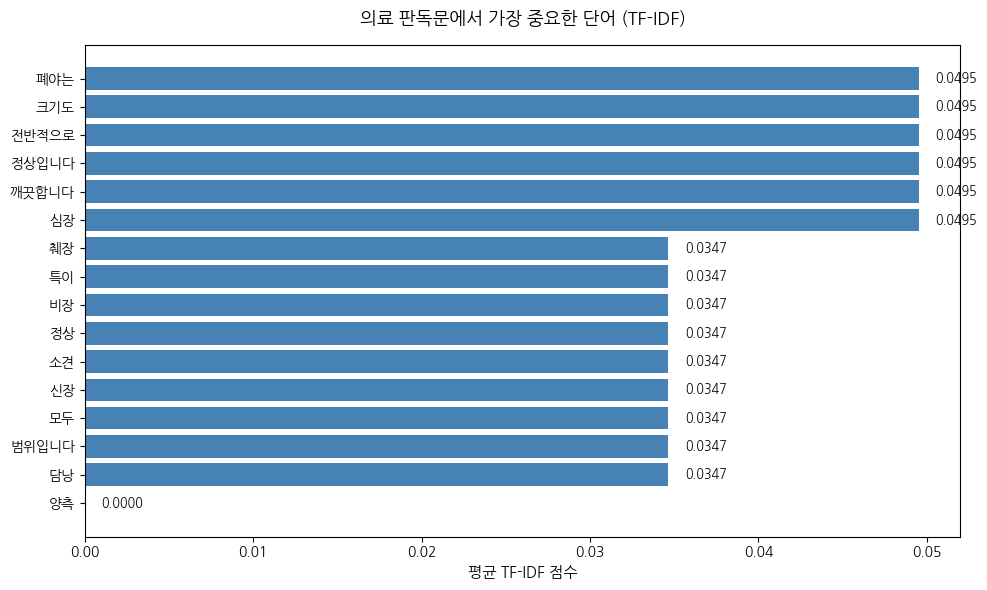

In [ ]:
# 전체 문서에서 가장 중요한 단어들 시각화
overall_tfidf = medical_tfidf_matrix.mean(axis=0)
top_n = 20
top_indices = np.argsort(overall_tfidf)[-top_n:][::-1]
top_words = [medical_vocab[i] for i in top_indices]
top_scores = [overall_tfidf[i] for i in top_indices]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(range(len(top_words)), top_scores, color='steelblue')
ax.set_yticks(range(len(top_words)))
ax.set_yticklabels(top_words)
ax.set_xlabel('평균 TF-IDF 점수', fontsize=11)
ax.set_title('의료 판독문에서 가장 중요한 단어 (TF-IDF)', fontsize=13, pad=15)
ax.invert_yaxis()

# 값 표시
for i, (bar, score) in enumerate(zip(bars, top_scores)):
    ax.text(score + 0.001, i, f'{score:.4f}',
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

---

## 6. scikit-learn을 사용한 구현

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 간단한 예제 문서
sklearn_docs = [
    "우측 폐 상엽 결절 관찰",
    "좌측 폐 하엽 음영 관찰",
    "양측 폐 결절 음영 관찰"
]

print("=" * 70)
print("scikit-learn을 사용한 BoW & TF-IDF:")
print("=" * 70)

# CountVectorizer (BoW)
count_vectorizer = CountVectorizer(token_pattern=r'[가-힣]+')
bow_sklearn = count_vectorizer.fit_transform(sklearn_docs)

print("\n[Bag-of-Words - CountVectorizer]")
print("어휘:", count_vectorizer.get_feature_names_out())
print("\nBoW 행렬:")
pd.DataFrame(bow_sklearn.toarray(),
                   columns=count_vectorizer.get_feature_names_out(),
                   index=[f'문서{i+1}' for i in range(len(sklearn_docs))])



scikit-learn을 사용한 BoW & TF-IDF:

[Bag-of-Words - CountVectorizer]
어휘: ['결절' '관찰' '상엽' '양측' '우측' '음영' '좌측' '폐' '하엽']

BoW 행렬:


,결절,관찰,상엽,양측,우측,음영,좌측,폐,하엽
문서1,1,1,1,0,1,0,0,1,0
문서2,0,1,0,0,0,1,1,1,1
문서3,1,1,0,1,0,1,0,1,0


---

In [ ]:

# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[가-힣]+')
tfidf_sklearn = tfidf_vectorizer.fit_transform(sklearn_docs)

print("\n\n[TF-IDF - TfidfVectorizer]")
print("TF-IDF 행렬:")
pd.DataFrame(tfidf_sklearn.toarray(),
                   columns=tfidf_vectorizer.get_feature_names_out(),
                   index=[f'문서{i+1}' for i in range(len(sklearn_docs))]).round(3)




[TF-IDF - TfidfVectorizer]
TF-IDF 행렬:


,결절,관찰,상엽,양측,우측,음영,좌측,폐,하엽
문서1,0.42,0.326,0.552,0.000,0.552,0.00,0.000,0.326,0.000
문서2,0.00,0.326,0.000,0.000,0.000,0.42,0.552,0.326,0.552
문서3,0.45,0.350,0.000,0.592,0.000,0.45,0.000,0.350,0.000


샘플 의료 데이터 원문:
[정상_1178] : 양측 폐야는 전반적으로 깨끗합니다. 심장 크기도 정상입니다.
[정상_165] : 간, 담낭, 췌장, 비장, 양측 신장 모두 정상 범위입니다. 특이 소견 없습니다.



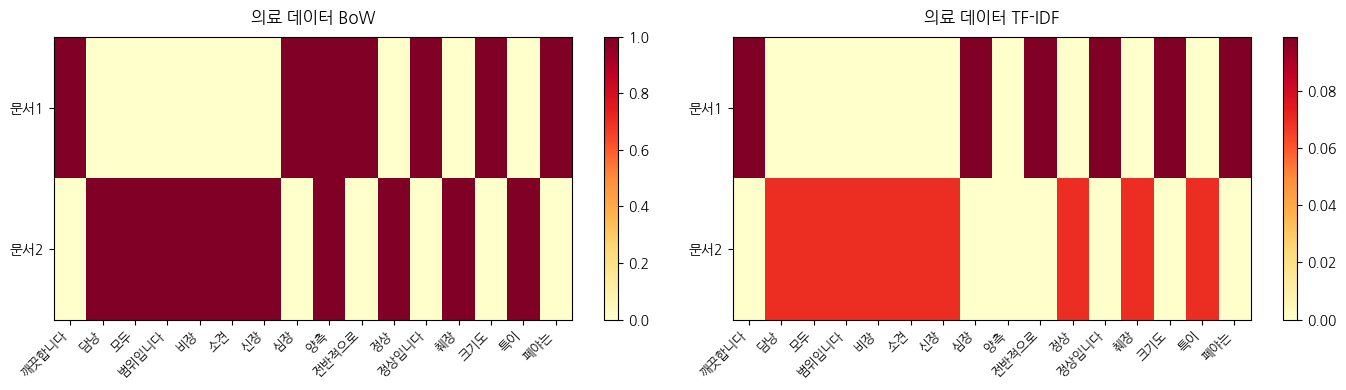


💡 의료 데이터 비교 분석:
----------------------------------------------------------------------
• TF-IDF는 BoW와 달리 단어의 빈도뿐만 아니라 문서 전체에서의 희소성을 고려하여 가중치를 부여합니다.
• 이를 통해 각 문서의 특징을 더 잘 나타내는 단어들을 부각시킬 수 있습니다.
• '정상입니다', '깨끗합니다'와 같이 자주 나오는 일반적인 단어들은 TF-IDF에서 가중치가 낮아지는 경향을 보입니다.


In [ ]:
print("=" * 70)
print("샘플 의료 데이터 원문:")
print("=" * 70)
for i, (label, doc) in enumerate(zip(sample_labels, sample_docs)):
    print(f"[{label}] : {doc}")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# BoW 히트맵
im1 = axes[0].imshow(medical_bow_matrix, cmap='YlOrRd', aspect='auto')
axes[0].set_xticks(np.arange(len(medical_vocab)))
axes[0].set_yticks(np.arange(len(sample_docs)))
axes[0].set_xticklabels(medical_vocab, rotation=45, ha='right', fontsize=9)
axes[0].set_yticklabels([f'문서{i+1}' for i in range(len(sample_docs))])
axes[0].set_title('의료 데이터 BoW', fontsize=12, pad=10)
plt.colorbar(im1, ax=axes[0])

# TF-IDF 히트맵
im2 = axes[1].imshow(medical_tfidf_matrix, cmap='YlOrRd', aspect='auto')
axes[1].set_xticks(np.arange(len(medical_vocab)))
axes[1].set_yticks(np.arange(len(sample_docs)))
axes[1].set_xticklabels(medical_vocab, rotation=45, ha='right', fontsize=9)
axes[1].set_yticklabels([f'문서{i+1}' for i in range(len(sample_docs))])
axes[1].set_title('의료 데이터 TF-IDF', fontsize=12, pad=10)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n💡 의료 데이터 비교 분석:")
print("-" * 70)
print("• TF-IDF는 BoW와 달리 단어의 빈도뿐만 아니라 문서 전체에서의 희소성을 고려하여 가중치를 부여합니다.")
print("• 이를 통해 각 문서의 특징을 더 잘 나타내는 단어들을 부각시킬 수 있습니다.")
print("• '정상입니다', '깨끗합니다'와 같이 자주 나오는 일반적인 단어들은 TF-IDF에서 가중치가 낮아지는 경향을 보입니다.")

## Summary

본 노트북은 자연어 처리의 기본적인 텍스트 벡터화 기법인 **Bag-of-Words (BoW)**와 **TF-IDF (Term Frequency - Inverse Document Frequency)**에 대해 학습하고, 실제 의료 판독문 데이터에 적용하는 과정을 다룹니다.

### 1. Bag-of-Words (BoW) 기초
*   텍스트를 단어의 출현 빈도로 표현하는 BoW 모델의 원리 이해.
*   간단한 예제 문서를 통해 어휘 사전 구축, BoW 벡터 생성 및 히트맵 시각화 과정을 실습.

### 2. TF-IDF 개념 및 계산
*   TF-IDF의 핵심 개념 (단순 빈도수의 한계 보완, 가중치 부여) 설명.
*   **TF (Term Frequency)**: 문서 내 단어 빈도를 정규화하여 문서 길이의 영향 제거.
*   **IDF (Inverse Document Frequency)**: 특정 문서에만 등장하는 단어에 높은 가중치를 부여.
*   TF와 IDF를 곱하여 최종 TF-IDF 가중치 계산 및 히트맵 시각화를 통해 BoW와의 차이점 분석.

### 3. 실제 의료 데이터 분석
*   `medical_reports.tsv` 파일을 로드하여 의료 판독문 데이터 준비.
*   카테고리별 샘플 문서를 추출하여 분석 대상 설정.
*   간단한 정규 표현식을 활용한 한국어 형태소 분석 (`tokenize_korean`) 함수 정의 및 불용어 처리.
*   샘플 의료 데이터에 BoW를 적용하여 빈번하게 등장하는 단어 확인.
*   TF-IDF를 적용하여 문서별 핵심 키워드를 추출하고, 전체 데이터에서 중요한 단어들을 TF-IDF 점수 기준으로 시각화.

### 4. scikit-learn을 사용한 구현
*   `CountVectorizer`를 사용하여 BoW 모델을 간편하게 구축하는 방법 시연.
*   `TfidfVectorizer`를 사용하여 TF-IDF 모델을 구현하는 방법 시연.
*   의료 데이터에 대한 BoW와 TF-IDF 시각화를 다시 비교하며, TF-IDF가 문서의 특징을 더 잘 나타냄을 확인.
